In [1]:
import torch
from diffusers import StableDiffusionPipeline

Load the Stable Diffusion model

In [2]:
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Get text embeddings

In [29]:
max_length = 50

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

prompt = "A futuristic car"

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

diffusion_model = pipe.unet
timesteps = 1
alpha_t = 0.5
criterion = nn.MSELoss()
optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)

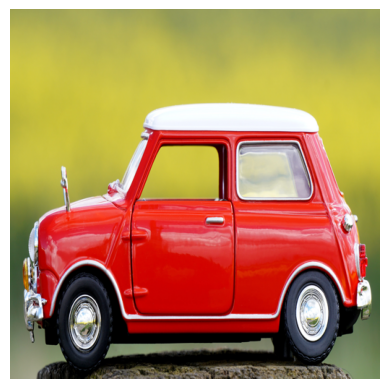

In [31]:
# load image in example/car.jpg and plot it

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

image_path = "../example/car.jpg"
image = Image.open(image_path).convert("RGB")
image = image.resize((512, 512))

plt.imshow(image)
plt.axis("off")
plt.show()

image = transforms.ToTensor()(image).unsqueeze(0)  # Add batch dimension
image = image.to(diffusion_model.device)

In [32]:
print(diffusion_model.forward.__code__.co_varnames)

('self', 'sample', 'timestep', 'encoder_hidden_states', 'class_labels', 'timestep_cond', 'attention_mask', 'cross_attention_kwargs', 'added_cond_kwargs', 'down_block_additional_residuals', 'mid_block_additional_residual', 'down_intrablock_additional_residuals', 'encoder_attention_mask', 'return_dict', 'default_overall_up_factor', 'forward_upsample_size', 'upsample_size', 'dim', 't_emb', 'emb', 'class_emb', 'aug_emb', 'hint', 'gligen_args', 'lora_scale', 'is_controlnet', 'is_adapter', 'down_block_res_samples', 'downsample_block', 'additional_residuals', 'res_samples', 'new_down_block_res_samples', 'down_block_res_sample', 'down_block_additional_residual', 'i', 'upsample_block', 'is_final_block')


In [ ]:
def optimize_embeddings(input_image, target_text, num_steps=5):
    tokens = tokenizer(target_text, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        e_tgt = text_encoder(tokens["input_ids"]).last_hidden_state

    # freeze diffusion model parameters
    for param in diffusion_model.parameters():
        param.requires_grad = False

    input_image = input_image.clone()
    
    for _ in range(num_steps):
        noise = torch.randn_like(input_image)
        sqrt_alpha = np.sqrt(alpha_t)
        input_image_noisy = sqrt_alpha * input_image + (1-sqrt_alpha) * noise
        
        noise_pred = diffusion_model(input_image_noisy, timestep=timesteps, encoder_hidden_states=e_tgt, attention_mask=tokens["attention_mask"])

        # update embeddings
        optimizer.zero_grad()
        loss = criterion(noise_pred, noise)
        loss.backward()
        optimizer.step()
    
    for param in diffusion_model.parameters():
        param.requires_grad = True

    # get the final embedding after update
    with torch.no_grad():
        x = text_encoder(tokens)

    return x

optimize_embeddings(image, prompt)

RuntimeError: Given groups=1, weight of size [320, 4, 3, 3], expected input[1, 3, 512, 512] to have 4 channels, but got 3 channels instead